# Visual Odometry (VO)

In this assignment, you do not need. a GPU. You will use the pykitti module and KITTI odometry dataset.

You can download the odometry data from [here](https://drive.google.com/file/d/1PJOUnM3nEwDpqiRvfqUnkNPJZpM4PKYV/view?usp=sharing).

## Monocular VO with OpenCV on KITTI

For each consecutive frame pair in the sequence, you will compute the relative pose between the frames and visualize it. You will use:

* pykitti code similar to what you wrote in mvs part to load the seqeunce with ground-truth info. (Check out the [demo code](https://github.com/utiasSTARS/pykitti/blob/master/demos/demo_odometry.py))
* OpenCV functions to compute and visualize the features and the essential matrix.

Please follow these steps to complete the assignment:

1. You can use the ORB Feature to do the feature matching:
    `orb = cv2.ORB_create()` to create the ORB object
    and then `orb.detectAndCompute()` to find the keypoints and descriptors on both frames

2. You can use brute-force matcher to match ORB descriptors:
    `bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)`

3. After matching the descriptors, sort the matched keypoints.

4. Draw matches on the two images using the `cv2.drawMatches()` function.

5. Compute the essential matrix using the `cv2.findEssentialMat()` function. Note that you need the matching points and the instrinsics for this function. 

6. Extract the rotation and translation from the essential matrix using the `cv2.recoverPose()` function.

7. Multiply the estimated rotation and translation with the previous rotation and translation. Initialize rotation to identity and translation to zeros on the first frame.

8. Display the current image with the keypoints on it using the `cv2.drawKeypoints()` function.

9. Update the previous rotation and translation as the current rotation and translation.

10. Draw the estimated trajectory as blue and ground-truth trajectory as green. You can use the `cv2.circle()` function.


You can create a video of your visualization of images and poses for the provided sequence.

**Bonus**: Compute the absolute trajectory error between the estimated trajectory and the ground-truth trajectory. 

Some examples repositories that might be useful:
* https://bitbucket.org/castacks/visual_odometry_tutorial/src/master/visual-odometry/
* https://github.com/uoip/monoVO-python


In [ ]:
!apt-get install -qq xattr
filename = "/content/drive/MyDrive/hw3/flow/flow.ipynb"
id = !xattr -p 'user.drive.id' {filename}
print(id)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/hw3/vo/

/content/drive/MyDrive/hw3/vo


In [5]:
pip install pykitti

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



Sequence: 09

Frame range: range(0, 20, 5)

First timestamp: 0:00:00
\First ground truth pose:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

Second ground truth pose:
[[ 0.9999 -0.0119  0.0125  0.0705]
 [ 0.0119  0.9999 -0.0029 -0.0288]
 [-0.0125  0.003   0.9999  1.5009]
 [ 0.      0.      0.      1.    ]]


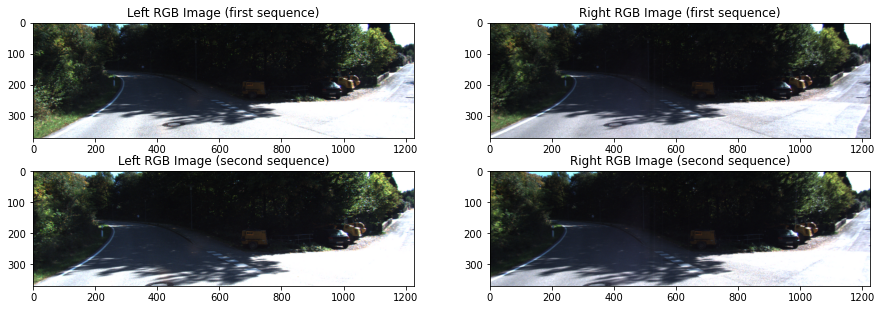

In [6]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pykitti
import cv2


# Change this to the directory where you store KITTI data
basedir = '/content/drive/MyDrive/hw3/vo/KITTI_odometry'

# Specify the dataset to load
sequence = '09'

# Load the data. Optionally, specify the frame range to load.
# dataset = pykitti.odometry(basedir, sequence)
dataset = pykitti.odometry(basedir, sequence, frames=range(0, 20, 5))

# Grab some data
first_pose = dataset.poses[0]
second_pose = dataset.poses[1]

first_rgb = dataset.get_rgb(0)
second_rgb = dataset.get_rgb(1)

first_cam2 = dataset.get_cam2(0)

# Display some of the data
np.set_printoptions(precision=4, suppress=True)
print('\nSequence: ' + str(dataset.sequence))
print('\nFrame range: ' + str(dataset.frames))

print('\nFirst timestamp: ' + str(dataset.timestamps[0]))
print('\First ground truth pose:\n' + str(first_pose))
print('\nSecond ground truth pose:\n' + str(second_pose))

f, ax = plt.subplots(2, 2, figsize=(15, 5))
ax[0, 0].imshow(first_rgb[0])
ax[0, 0].set_title('Left RGB Image (first sequence)')

ax[0, 1].imshow(first_rgb[1])
ax[0, 1].set_title('Right RGB Image (first sequence)')

ax[1, 0].imshow(second_rgb[0])
ax[1, 0].set_title('Left RGB Image (second sequence)')

ax[1, 1].imshow(second_rgb[1])
ax[1, 1].set_title('Right RGB Image (second sequence)')

plt.show()

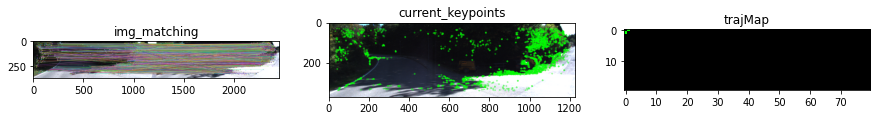

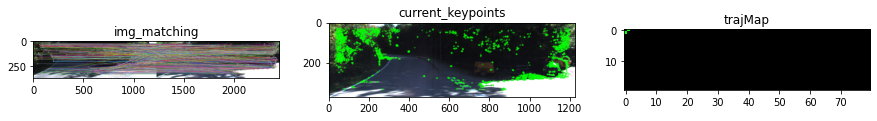

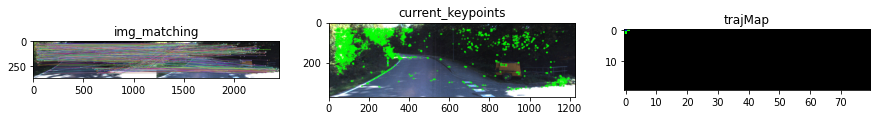

In [19]:
# You can use the ORB Feature to do the feature matching: orb = cv2.ORB_create() 

orb = cv2.ORB_create(nfeatures=6000)

for i in range(1, 4):
  trajMap = np.zeros((20, 80, 3), dtype=np.uint8)

  # ORB fails to detect any features on the left img, so get right img
  img_t0 = np.array(dataset.get_rgb(i-1)[1])
  img_t1 = np.array(dataset.get_rgb(i)[1])

  # to create the ORB object and then orb.detectAndCompute() to find the keypoints and descriptors on both frames
  keypoints_t0, descriptors_t0 = orb.detectAndCompute(img_t0, None)
  keypoints_t1, descriptors_t1 = orb.detectAndCompute(img_t1, None)

  # You can use brute-force matcher to match ORB descriptors
  matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  matched = matcher.match(descriptors_t0, descriptors_t1)
  matched = sorted(matched, key=lambda x: x.distance)
  img_matching = cv2.drawMatches(img_t0, keypoints_t0, img_t1, keypoints_t1, matched, None)

  # Compute the essential matrix using the cv2.findEssentialMat() function. 
  # Note that you need the matching points and the instrinsics for this function.
  # intrinsics taken from stereo.ipynb
  K = dataset.calib.K_cam3
  f = K[0,0]
  cx = K[0, 2]
  cy = K[1, 2]

  points1 = np.float32([keypoints_t0[match.queryIdx].pt for match in matched])
  points2 = np.float32([keypoints_t1[match.trainIdx].pt for match in matched])
  E, mask = cv2.findEssentialMat(points1, points2, focal=f, pp=(cx, cy), method=cv2.RANSAC, prob=0.999, threshold=1)
  
  # Extract the rotation and translation from the essential matrix 
  # using the cv2.recoverPose() function.
  points1 = points1[mask.ravel() == 1]
  points2 = points2[mask.ravel() == 1]
  points, R, t, mask = cv2.recoverPose(E, points1, points2, focal=f, pp=(cx, cy))

  # Multiply the estimated rotation and translation with the previous 
  # rotation and translation. Initialize rotation to identity and translation 
  # to zeros on the first frame.
  
  R_0 = np.dot(R_prev, R) if i > 1 else np.eye(3)
  t_0 = np.dot(R_prev, t) + t_prev if i > 1 else np.zeros(3).reshape(3, 1)
  R_gt = np.dot(R_gt_prev, R_gt) if i > 1 else np.eye(3)
  t_gt = np.dot(R_gt_prev, t_gt) + t_gt_prev if i > 1 else np.zeros(3).reshape(3, 1)


  R_prev = R_0
  t_prev = t_0
  R_gt_prev = R_gt
  t_gt_prev = t_gt

  # Display the current image with the keypoints on it using the cv2.drawKeypoints() function
  current_keypoints = cv2.drawKeypoints(img_t1, keypoints_t1, None, color=(0, 255, 0), flags=0)


  # Update the previous rotation and translation as the current rotation and translation.
  # Draw the estimated trajectory as blue and ground-truth trajectory as green. 
  # You can use the cv2.circle() function.

  cv2.circle(trajMap, (int(t_0[0]), int(t_0[2])), 1, (0,0,255), 1)
  cv2.circle(trajMap, (int(t_gt[0]), int(t_gt[2])), 1, (0,255,0), 1)
  
  f, ax = plt.subplots(1, 3, figsize=(15, 5))
  ax[0].imshow(img_matching)
  ax[0].set_title('img_matching')

  ax[1].imshow(current_keypoints)
  ax[1].set_title('current_keypoints')

  ax[2].imshow(trajMap)
  ax[2].set_title('trajMap')
  plt.show()